In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [3]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web2 = pd.read_csv("vnf_data/csv_experiments_WEB2.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
web1["vnf"] = "nginx"
web2["vnf"] = "haproxy"
web3["vnf"] = "squid"

mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "throughput",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"

mapping02 = mapping.copy()
mapping02["param__func__de.upb.lb-haproxy.0.1__cpu_bw"] = "CPU"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"

web1 = select_and_rename(web1, mapping01)
web2 = select_and_rename(web2, mapping02)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web2 = replaceSize(web2)
web3 = replaceSize(web3)

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [4]:
# select sub-datasets with small and large flows
web1_small = web1.loc[web1["size"] == "small"]
web1_big = web1.loc[web1["size"] == "big"]

web2_small = web2.loc[web2["size"] == "small"]
web2_big = web2.loc[web2["size"] == "big"]

web3_small = web3.loc[web3["size"] == "small"]
web3_big = web3.loc[web3["size"] == "big"]

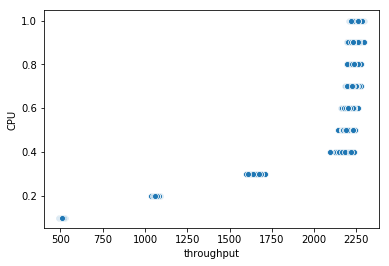

In [7]:
# plot cpu and throughput
# sns.scatterplot(web1_small['CPU'], web1_small['throughput'])
sns.scatterplot(web1_small['throughput'], web1_small['CPU'])

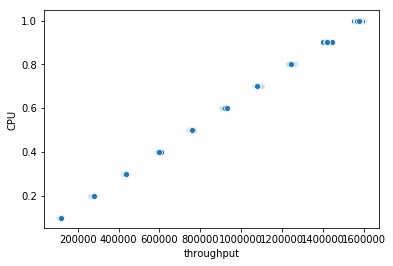

In [8]:
sns.scatterplot(web1_big['throughput'], web1_big['CPU'])

c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


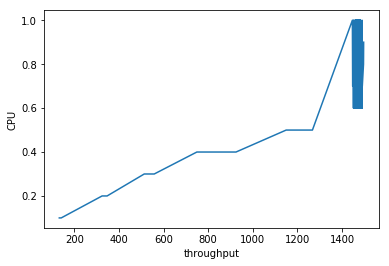

In [14]:
sns.scatterplot(web2_small['throughput'], web2_small['CPU'])

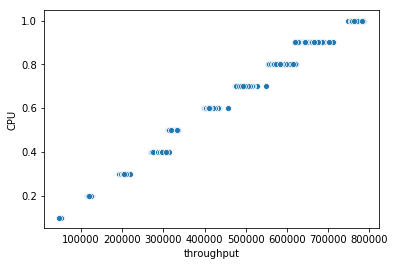

In [11]:
sns.scatterplot(web2_big['throughput'], web2_big['CPU'])

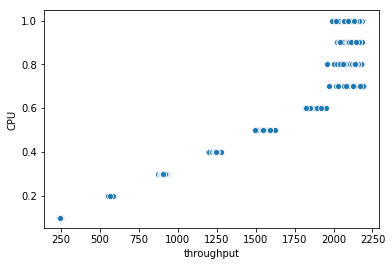

In [12]:
sns.scatterplot(web3_small['throughput'], web3_small['CPU'])

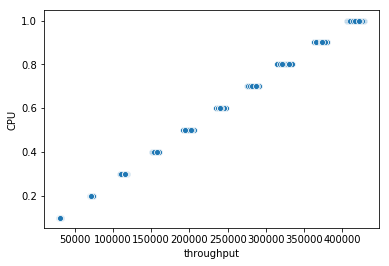

In [13]:
sns.scatterplot(web3_big['throughput'], web3_big['CPU'])